# Construct Hamiltonian in symmetry reduced basis

Code copied from https://quspin.github.io/QuSpin/examples/example14.html#example14-label

In [1]:

#### CHOOSE SYSTEM SIZE HERE
N = 25 # total number of lattice sites
#####################
from __future__ import print_function, division
import sys,os
# os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='8' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='8' # set number of MKL threads to run in parallel
#
quspin_path = os.path.join(os.getcwd(),"../../")
sys.path.insert(0,quspin_path)
###########################################################################
#                            example 14                                   #
#  In this script we demonstrate how to use the user_basis to construct   #
#  a spin-1/2 Hamiltonian on a restricted Hilbert space where a spin-up   #
#  on a given lattice site must be preceded and succeeded by a spin-down. #
###########################################################################
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d # Hilbert space spin basis_1d
from quspin.basis.user import user_basis # Hilbert space user basis
from quspin.basis.user import pre_check_state_sig_32,op_sig_32,map_sig_32 # user basis data types
from numba import carray,cfunc # numba helper functions
from numba import uint32,int32 # numba data types
import numpy as np
######  function to call when applying operators
@cfunc(op_sig_32, locals=dict(s=int32,b=uint32))
def op(op_struct_ptr,op_str,ind,N,args):
    # using struct pointer to pass op_struct_ptr back to C++ see numba Records
    op_struct = carray(op_struct_ptr,1)[0]
    err = 0
    ind = N - ind - 1 # convention for QuSpin for mapping from bits to sites.
    s = (((op_struct.state>>ind)&1)<<1)-1
    b = (1<<ind)
    #
    if op_str==120: # "x" is integer value 120 (check with ord("x"))
        op_struct.state ^= b
    elif op_str==121: # "y" is integer value 120 (check with ord("y"))
        op_struct.state ^= b
        op_struct.matrix_ele *= 1.0j*s
    elif op_str==122: # "z" is integer value 120 (check with ord("z"))
        op_struct.matrix_ele *= s
    else:
        op_struct.matrix_ele = 0
        err = -1
    #
    return err
#
op_args=np.array([],dtype=np.uint32)
#
######  function to filter states/project states out of the basis
#
@cfunc(pre_check_state_sig_32,
    locals=dict(s_shift_left=uint32,s_shift_right=uint32), )
def pre_check_state(s,N,args):
    """ imposes that that a bit with 1 must be preceded and followed by 0,
    i.e. a particle on a given site must have empty neighboring sites.
    #
    Works only for lattices of up to N=32 sites (otherwise, change mask)
    #
    """
    mask = (0xffffffff >> (32 - N)) # works for lattices of up to 32 sites
    # cycle bits left by 1 periodically
    s_shift_left = (((s << 1) & mask) | ((s >> (N - 1)) & mask))
    #
    # cycle bits right by 1 periodically
    s_shift_right = (((s >> 1) & mask) | ((s << (N - 1)) & mask))
    #
    return (((s_shift_right|s_shift_left)&s))==0
#
pre_check_state_args=None
#
######  construct user_basis 
# define maps dict
maps = dict() # no symmetries to apply.
# define op_dict
op_dict = dict(op=op,op_args=op_args)
# define pre_check_state
pre_check_state=(pre_check_state,pre_check_state_args) # None gives a null pointer to args
# create user basis
basis = user_basis(np.uint32,N,op_dict,allowed_ops=set("xyz"),sps=2,
                    pre_check_state=pre_check_state,Ns_block_est=300000,**maps)
###### construct Hamiltonian
# site-coupling lists
h_list  = [[1.0,i] for i in range(N)]
# operator string lists
static = [["x",h_list],]
# compute Hamiltonian, no checks have been implemented
no_checks=dict(check_symm=False, check_pcon=False, check_herm=False)
H = hamiltonian(static,[],basis=basis,dtype=np.float64,**no_checks)
print("Basis size:"+str(basis.Ns))

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

# Calculate time-evolved staggered magnetization for a fixed Omega

Text(0.5, 0, 'Time $\\Omega t$')

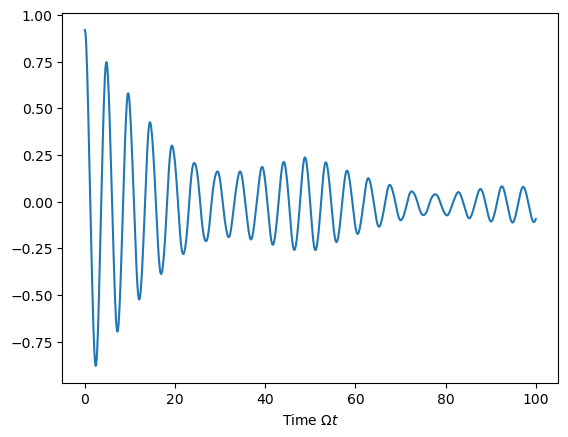

In [ ]:
# Initial state: neel state |0101010...>
initstate=np.zeros(basis.Ns)
initstate[0]=1.0
# Construct staggered magnetization
stag_mag = hamiltonian([["z",[[(-1)**i/N,i] for i in range(N)]]],[],basis=basis,dtype=np.float64,**no_checks)
# Evolve state
times=np.linspace(0,100,1000)
psi_t=H.evolve(initstate,0,times)
# Calculate magnetization
stag_t=np.real(stag_mag.expt_value(psi_t,enforce_pure=True))
# Plot evolution
import matplotlib.pyplot as plt
plt.plot(times,stag_t)
plt.xlabel("Time $\Omega t$")

# Resample the time-evolution

In [ ]:
thetas=np.logspace(-3,-0.5,100) #standard deviation of Gaussian
Naver=10000
result=np.zeros((thetas.size,times.size//2))
times_for_averaging=times[:times.size//2] #only average using half the times to not blow interp limit
for theta in thetas:
    # sample Gaussian random numbers
    deltas=np.random.normal(scale=theta,size=Naver)
    for delta in deltas:
        # Evaluate at new time points
        new_times=times_for_averaging*(1+delta)
        # evaluate mags using interpolation
        new_mag=np.interp(new_times, times, stag_t)
        # add to result array
        result[theta==thetas]+=new_mag/Naver

Text(0.5, 0, 'Time $\\Omega t$ ')

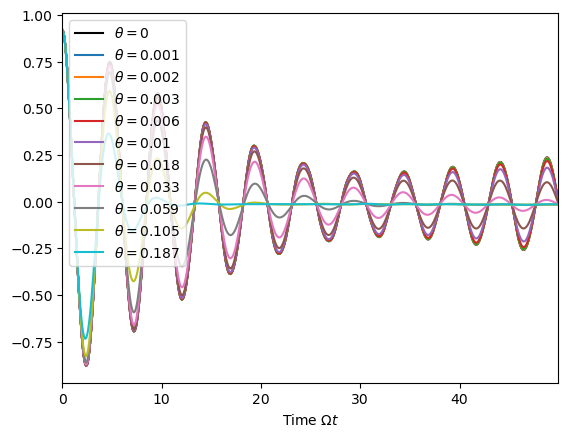

In [ ]:
plt.plot(times,stag_t,color='k',label=r'$\theta=0$')
for i in range(thetas.size//10):
    plt.plot(times_for_averaging,result[i*10],label=r'$\theta='+str(np.round(thetas[i*10],3))+'$')
plt.legend()
plt.xlim(0,np.max(times_for_averaging))
plt.xlabel("Time $\Omega t$ ")

In [ ]:
np.save('thetas',thetas)
np.save('times',times_for_averaging)
np.save('stagmag_averaged',result)